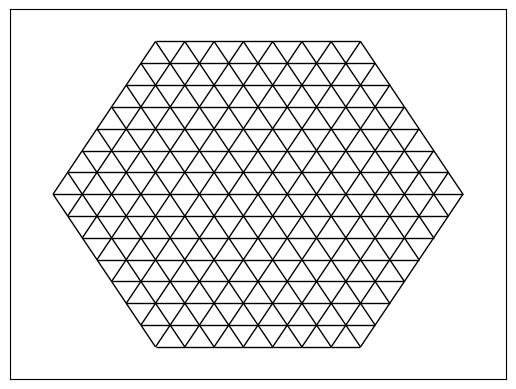

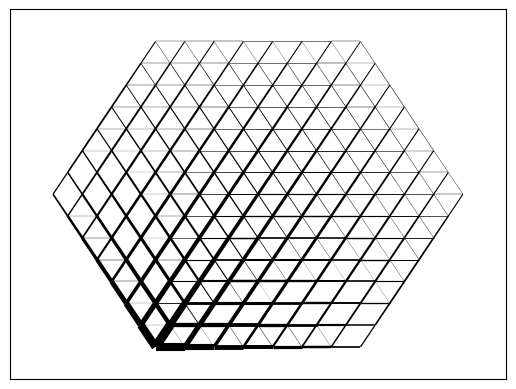

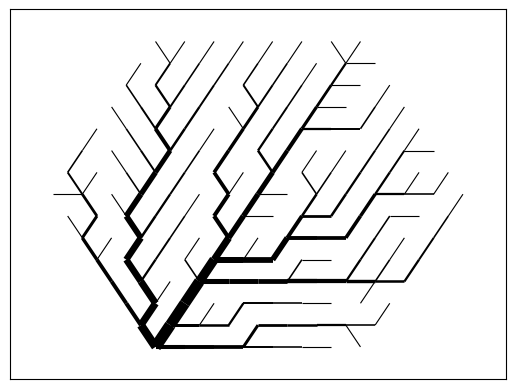

In [6]:
import igraph as ig
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define hexagonal neighbor shifts
NEIGHBORS = [(0, -1, 1), (1, -1, 0), (1, 0, -1), (0, 1, -1), (-1, 1, 0), (-1, 0, 1)]

def tooFar(q, r, s, maxdistance):
    """Check if the given coordinates are beyond the specified max distance."""
    distance = max([abs(q), abs(r), abs(s)])
    return distance > maxdistance

def makeHex(q, r, s, maxdistance, visited):
    """Recursively generate hexagonal grid within the max distance."""
    visited.add((q, r, s))
    for n in NEIGHBORS:
        nq, nr, ns = q + n[0], r + n[1], s + n[2]
        if tooFar(nq, nr, ns, maxdistance) or (nq, nr, ns) in visited:
            continue
        makeHex(nq, nr, ns, maxdistance, visited)

def create_graph(visited):
    """Create an igraph graph from the visited hex coordinates."""
    g = ig.Graph()

    vertex_coords_map = {}
    for q, r, s in visited:
        v = g.add_vertex()
        v["x"] = np.sqrt(3) * q + np.sqrt(3) / 2 * r
        v["y"] = 3 / 2 * r
        vertex_coords = f"({q},{r},{s})"
        v["name"] = vertex_coords
        v["color"] = "red" if (q, r, s) == (-7, 7, 0) else "grey"
        vertex_coords_map[vertex_coords] = v.index

    for q, r, s in visited:
        vertex_coords = f"({q},{r},{s})"
        for n in NEIGHBORS:
            nq, nr, ns = q + n[0], r + n[1], s + n[2]
            neighbor_coords = f"({nq},{nr},{ns})"
            if neighbor_coords in vertex_coords_map:
                try:
                    g.add_edge(vertex_coords_map[vertex_coords], vertex_coords_map[neighbor_coords])
                except ig.InternalError:
                    pass  # Neighbor not added yet

    g.simplify()  # Remove duplicate edges
    return g

def igraph_to_networkx(g):
    """Convert igraph graph to NetworkX graph."""
    G = nx.Graph()
    for v in g.vs:
        G.add_node(v.index, pos=(v["x"], v["y"]))
    for e in g.es:
        G.add_edge(e.source, e.target)
    return G

def initialize_current(g, i_0=1000):
    """Initialize currents for each vertex in the graph."""
    N_nodes = len(g.vs)
    currents = -i_0 / (N_nodes - 1) * np.ones(N_nodes)
    
    # Identify the bottom left node
    bottom_left_index = None
    min_y = float('inf')
    min_x = float('inf')
    for v in g.vs:
        if v['y'] < min_y or (v['y'] == min_y and v['x'] < min_x):
            min_y = v['y']
            min_x = v['x']
            bottom_left_index = v.index
    
    currents[bottom_left_index] = i_0
    return currents

def draw_lattice(k, I, g, K=1, gamma=2, iterations=150, regularization=1e-6):
    """Iteratively update the lattice and return the resulting NetworkX graph."""
    Gamma = (2 * gamma) / (gamma + 1)
    for _ in range(iterations):
        lamb = np.sum(k, axis=0)
        Lambda = np.diag(lamb) + regularization * np.eye(len(lamb))  # Add regularization to the diagonal
        Uvec = np.linalg.solve(Lambda - k, I)
        delta_U = np.subtract.outer(Uvec, Uvec)
        I_new = k * delta_U
        k_new = np.abs(I_new) ** -(Gamma - 2)
        k = k_new / K
    I_new = np.where(I_new > 0.1, I_new, 0)
    G = nx.from_numpy_array(I_new)
    for i, v in enumerate(g.vs):
        G.add_node(i, pos=(v['x'], v['y']))
    return G

def plot_graph(G, pos, filename):
    """Plot and save the graph using NetworkX and Matplotlib."""
    weights = [np.sqrt(G[u][v]['weight']) for u, v in G.edges]
    weights = np.divide(weights, 3)
    nx.draw_networkx_edges(G, pos=pos, width=weights)
    plt.savefig(filename)
    plt.show()

# Main code execution
if __name__ == "__main__":
    visited = set()
    maxdistance = 7
    makeHex(0, 0, 0, maxdistance, visited)

    g = create_graph(visited)
    G = igraph_to_networkx(g)
    pos = nx.get_node_attributes(G, 'pos')

    # Plot initial lattice
    nx.draw_networkx_edges(G, pos=pos)
    plt.savefig("underlying_lattice.png")
    plt.show()

    A = np.array(g.get_adjacency().data)
    I = initialize_current(g)

    # Initialize k
    indices = np.nonzero(np.tril(A))
    k = np.zeros(A.shape)
    for i, j in zip(*indices):
        k[i, j] = k[j, i] = np.random.rand()

    # Draw lattice for gamma=2
    G = draw_lattice(k, I, g, K=1, gamma=2)
    plot_graph(G, pos, "bohn_fig2a.png")

    # Draw lattice for gamma=1/2
    G = draw_lattice(k, I, g, K=1, gamma=1/2)
    plot_graph(G, pos, "bohn_fig2b.png")
